In [107]:
import os
from pathlib import Path
PARENT_PATH = Path(os.getcwd()).parent.absolute()
import pandas as pd

from capstone.config import CapstoneConfig
from capstone.data_access import DataClass

In [108]:
config = CapstoneConfig()
config.CURRENT_PATH = PARENT_PATH

data = DataClass(config)

In [109]:
# load data
xls = pd.ExcelFile(os.path.join(data.data_path, "Regulatory Requirements.xlsx"))
df = pd.read_excel(xls,'Requirements List')

In [110]:
# data shape
df.shape

(10232, 13)

In [111]:
# data preprocess
df1 = df.copy()
df1['Standard mapping?'].replace('\n','', regex=True,inplace = True)
df1['Standard mapping?'] = df1['Standard mapping?'].str.split(',')

In [112]:
df1

,id,Regulation,Title / Chapter / Sub part,Chapter / Section,Article / Paragraph,Text,Date,Product Type,GxP,Regulatory Requirement Type,Full article reference,Mapped to a standard?,Standard mapping?
0,1,Brazil ANVISA GMP MD,Chapter 2 General Quality System Requirements,2.1. General Provisions,2.1.1,General Quality System Requirements […] Genera...,2013-03-28 00:00:00,Medical Device,GMP,Core,Brazil ANVISA GMP MD 2.1.1,Mapped to a standard,[Regulatory Standards Management]
1,2,Brazil ANVISA GMP MD,Chapter 2 General Quality System Requirements,2.2. Management responsibility,2.2.1,General Quality System Requirements […] Manage...,2013-03-28 00:00:00,Medical Device,GMP,Core,Brazil ANVISA GMP MD 2.2.1,Mapped to a standard,"[Quality Planning, Quality Management]"
2,3,Brazil ANVISA GMP MD,Chapter 2 General Quality System Requirements,2.2. Management responsibility,2.2.2,General Quality System Requirements […] Manage...,2013-03-28 00:00:00,Medical Device,GMP,Core,Brazil ANVISA GMP MD 2.2.2,Mapped to a standard,[Quality Management]
3,4,Brazil ANVISA GMP MD,Chapter 2 General Quality System Requirements,2.2. Management responsibility,2.2.3,General Quality System Requirements […] Manage...,2013-03-28 00:00:00,Medical Device,GMP,Core,Brazil ANVISA GMP MD 2.2.3,Mapped to a standard,[Quality Management]
4,5,Brazil ANVISA GMP MD,Chapter 2 General Quality System Requirements,2.2. Management responsibility,2.2.4,General Quality System Requirements […] Manage...,2013-03-28 00:00:00,Medical Device,GMP,Core,Brazil ANVISA GMP MD 2.2.4,Mapped to a standard,"[Training, SaMD, Quality Management]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10227,10237,EU IVDR 2017/746,"CHAPTER VII\nPOST-MARKET SURVEILLANCE, VIGILAN...",Section 1\nPost-market surveillance,78.2,The post-market surveillance system shall be s...,NaN,Medical device,GMP,Non-core,EU IVDR VII Article 78.2,Mapped to a standard,[Medical Device Post Market Surveillance]
10228,10238,EU IVDR 2017/746,"CHAPTER VII\nPOST-MARKET SURVEILLANCE, VIGILAN...",Section 1\nPost-market surveillance,78.3,Data gathered by the manufacturer's post-marke...,NaN,Medical device,GMP,Non-core,EU IVDR VII Article 78.3,Mapped to a standard,[Medical Device Post Market Surveillance]
10229,10239,EU IVDR 2017/746,"CHAPTER VII\nPOST-MARKET SURVEILLANCE, VIGILAN...",Section 1\nPost-market surveillance,78.4,"If, in the course of the post-market surveilla...",NaN,Medical device,GMP,Non-core,EU IVDR VII Article 78.4,Mapped to a standard,[Medical Device Post Market Surveillance]
10230,10240,EU MDR 2017/745,CHAPTER I\nSCOPE AND DEFINITIONS,NaN,Article 2.35\nDefinitions,"‘economic operator’ means a manufacturer, an a...",NaN,Medical device,GMP,Core,EU MDR Article 2 (35),Mapped to a standard,[Medical Device Post Market Surveillance]


# number of samples by category

In [113]:
# dataframe with labels
df2 = df1[df1['Mapped to a standard?'] != 'No mapping']
df2.reset_index(drop=True, inplace=True)

In [114]:
df2

,id,Regulation,Title / Chapter / Sub part,Chapter / Section,Article / Paragraph,Text,Date,Product Type,GxP,Regulatory Requirement Type,Full article reference,Mapped to a standard?,Standard mapping?
0,1,Brazil ANVISA GMP MD,Chapter 2 General Quality System Requirements,2.1. General Provisions,2.1.1,General Quality System Requirements […] Genera...,2013-03-28 00:00:00,Medical Device,GMP,Core,Brazil ANVISA GMP MD 2.1.1,Mapped to a standard,[Regulatory Standards Management]
1,2,Brazil ANVISA GMP MD,Chapter 2 General Quality System Requirements,2.2. Management responsibility,2.2.1,General Quality System Requirements […] Manage...,2013-03-28 00:00:00,Medical Device,GMP,Core,Brazil ANVISA GMP MD 2.2.1,Mapped to a standard,"[Quality Planning, Quality Management]"
2,3,Brazil ANVISA GMP MD,Chapter 2 General Quality System Requirements,2.2. Management responsibility,2.2.2,General Quality System Requirements […] Manage...,2013-03-28 00:00:00,Medical Device,GMP,Core,Brazil ANVISA GMP MD 2.2.2,Mapped to a standard,[Quality Management]
3,4,Brazil ANVISA GMP MD,Chapter 2 General Quality System Requirements,2.2. Management responsibility,2.2.3,General Quality System Requirements […] Manage...,2013-03-28 00:00:00,Medical Device,GMP,Core,Brazil ANVISA GMP MD 2.2.3,Mapped to a standard,[Quality Management]
4,5,Brazil ANVISA GMP MD,Chapter 2 General Quality System Requirements,2.2. Management responsibility,2.2.4,General Quality System Requirements […] Manage...,2013-03-28 00:00:00,Medical Device,GMP,Core,Brazil ANVISA GMP MD 2.2.4,Mapped to a standard,"[Training, SaMD, Quality Management]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3901,10237,EU IVDR 2017/746,"CHAPTER VII\nPOST-MARKET SURVEILLANCE, VIGILAN...",Section 1\nPost-market surveillance,78.2,The post-market surveillance system shall be s...,NaN,Medical device,GMP,Non-core,EU IVDR VII Article 78.2,Mapped to a standard,[Medical Device Post Market Surveillance]
3902,10238,EU IVDR 2017/746,"CHAPTER VII\nPOST-MARKET SURVEILLANCE, VIGILAN...",Section 1\nPost-market surveillance,78.3,Data gathered by the manufacturer's post-marke...,NaN,Medical device,GMP,Non-core,EU IVDR VII Article 78.3,Mapped to a standard,[Medical Device Post Market Surveillance]
3903,10239,EU IVDR 2017/746,"CHAPTER VII\nPOST-MARKET SURVEILLANCE, VIGILAN...",Section 1\nPost-market surveillance,78.4,"If, in the course of the post-market surveilla...",NaN,Medical device,GMP,Non-core,EU IVDR VII Article 78.4,Mapped to a standard,[Medical Device Post Market Surveillance]
3904,10240,EU MDR 2017/745,CHAPTER I\nSCOPE AND DEFINITIONS,NaN,Article 2.35\nDefinitions,"‘economic operator’ means a manufacturer, an a...",NaN,Medical device,GMP,Core,EU MDR Article 2 (35),Mapped to a standard,[Medical Device Post Market Surveillance]


In [115]:
labels_dict = {}
for i in range(df2.shape[0]):
    for j in range(len(df2['Standard mapping?'][i])):
        label = df2['Standard mapping?'][i][j].strip()
        if label == '':
            continue
        if label not in list(labels_dict.keys()):
            labels_dict[label] = 1
        else:
            labels_dict[label] += 1

In [116]:
sorted_dict = dict(sorted(labels_dict.items(), key=lambda item: item[1]))

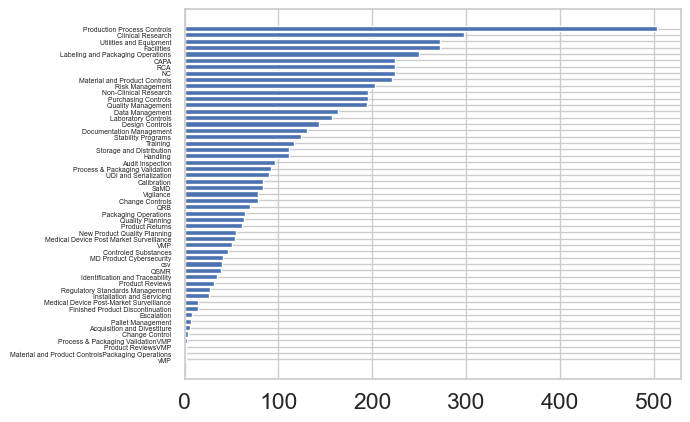

In [117]:
import matplotlib.pyplot as plt

names = list(sorted_dict.keys())
values = list(sorted_dict.values())

plt.barh(range(len(labels_dict)), values, tick_label=names)
plt.yticks(fontsize=5)
plt.show()

# word frequency analysis

In [20]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections


import nltk
from nltk.corpus import stopwords
import re
import networkx

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

In [21]:
# extract all the words from text, not including numbers
df3 = df2.copy()
for i in range(df3.shape[0]):
    df3['Text'][i] = " ".join(re.sub("([^A-Za-z \t])|(\w+:\/\/\S+)", "", df3['Text'][i]).split())
    #df3['Text'][i] = " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", df3['Text'][i]).split())
    df3['Text'][i] = df3['Text'][i].lower().split()
    words = df3['Text'][i]

    
    
    
    

In [24]:
stop_words = set(stopwords.words('english'))
df3['Text'] = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in df3['Text']]

In [27]:
tweets_nsw = df3['Text']
all_words_nsw = list(itertools.chain(*tweets_nsw))
counts_nsw = collections.Counter(all_words_nsw)
counts_nsw.most_common(15)

[('shall', 2275),
 ('quality', 2243),
 ('product', 1661),
 ('control', 1308),
 ('device', 1248),
 ('data', 1127),
 ('products', 1110),
 ('materials', 991),
 ('management', 983),
 ('system', 968),
 ('procedures', 866),
 ('appropriate', 865),
 ('requirements', 864),
 ('production', 863),
 ('manufacturer', 859)]

Text(0.5, 1.0, 'Common Words Found in Tweets (Without Stop Words)')

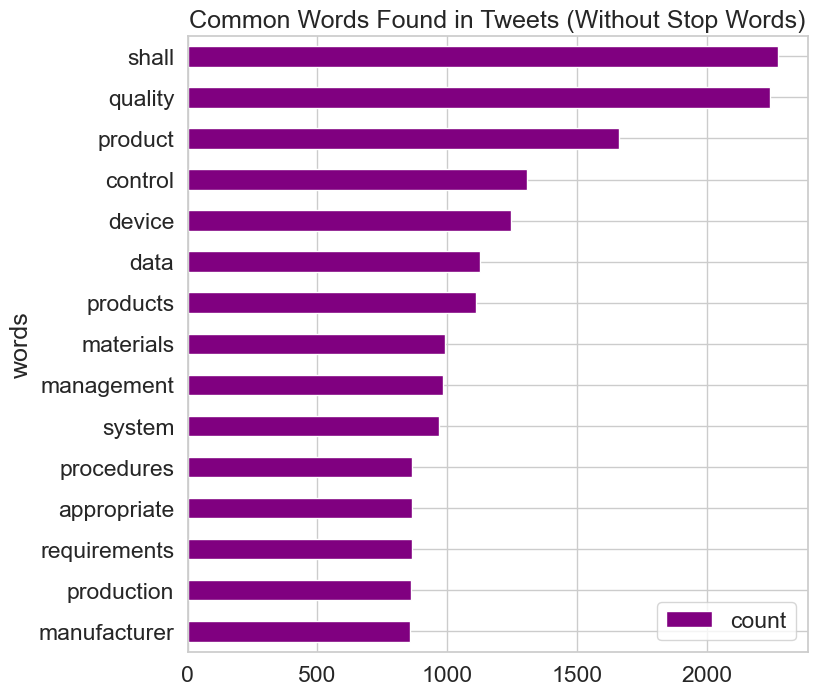

In [28]:
clean_tweets_nsw = pd.DataFrame(counts_nsw.most_common(15),
                             columns=['words', 'count'])
fig, ax = plt.subplots(figsize=(8, 8))
# Plot horizontal bar graph
clean_tweets_nsw.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")
ax.set_title("Common Words Found in Tweets (Without Stop Words)")


# sentence length analysis

In [30]:
length = 0
for i in range(len(df3['Text'])):
    length += len(df3['Text'][i])

40.193292370711724

In [82]:
names = list(sorted_dict.keys())
values = list(sorted_dict.values())

In [85]:
lengths = []
counts = []
for name in names:
    count = 0
    length = 0
    for i in range(len(df3['Text'])):
        if name in df3['Standard mapping?'][i]:
            count += 1
            length += len(df3['Text'][i])
    counts.append(count)
    lengths.append(length)          

In [86]:
avg_len = []
for i in range(len(names)):
    if counts[i] == 0:
        avg_len.append(0)
    else:
        avg_len.append(round(lengths[i]/counts[i],2))

In [87]:
data_tuples = list(zip(names,avg_len))

In [89]:
df_len = pd.DataFrame(data_tuples, columns=['labels','avg_len'])

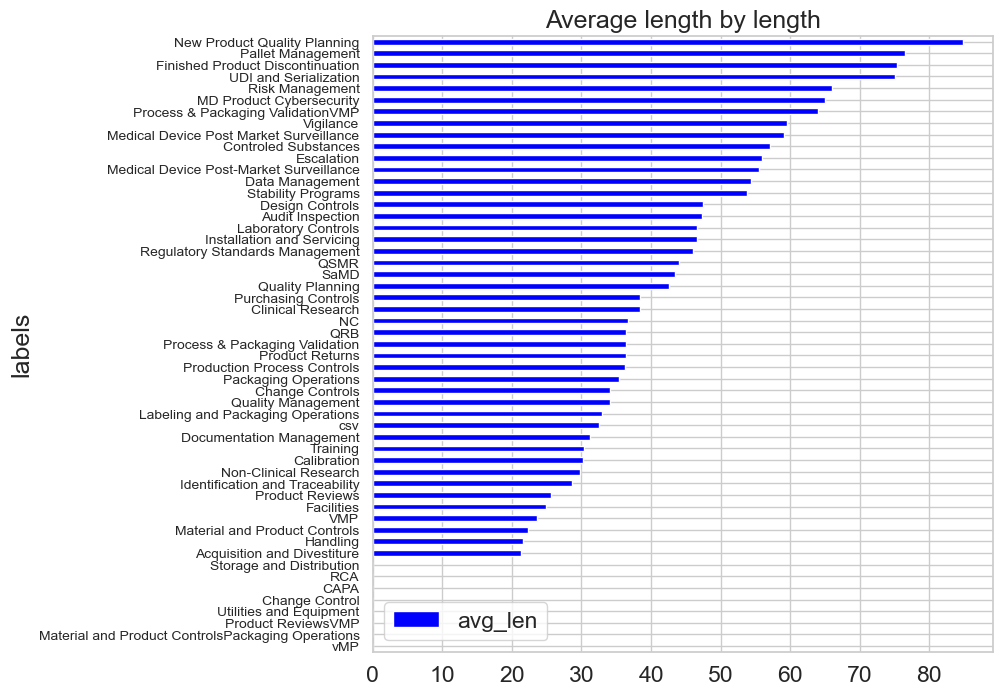

In [106]:
fig, ax = plt.subplots(figsize=(8, 8))
# Plot horizontal bar graph
df_len.sort_values(by='avg_len').plot.barh(x='labels',y='avg_len',ax=ax,
                                         color="blue")
ax.set_title("Average length by length")
ax.yaxis.set_tick_params(labelsize=10)

# distribution of length

In [120]:
df4 = df3.copy()
text_length = []
for i in range(len(df4['Text'])):
    text_length.append(len(df4['Text'][i]))
df4['Text_length'] = text_length

Text(0, 0.5, 'Counts')

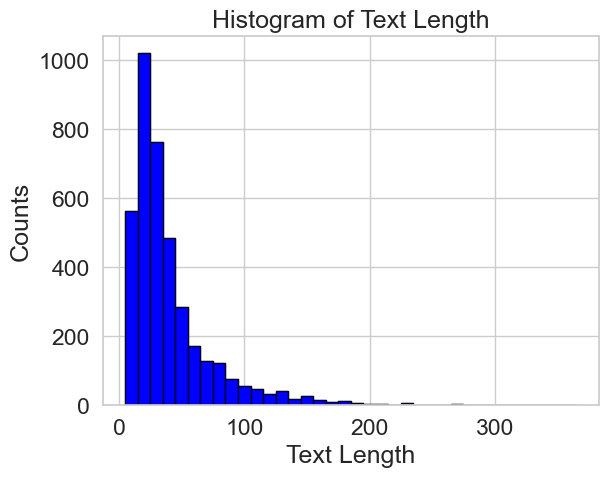

In [125]:
# matplotlib histogram
plt.hist(df4['Text_length'], color = 'blue', edgecolor = 'black',
         bins = int(180/5))

# seaborn histogram
sns.distplot(df4['Text_length'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Counts')
